In [1]:
import glob
import importlib
import os

In [2]:
import cv2
import numpy as np
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import nitelite_mapmaker

In [5]:
importlib.reload(nitelite_mapmaker)

<module 'nitelite_mapmaker' from '/Users/Shared/repos/NITELite-mapmaker/nitelite_mapmaker/__init__.py'>

# Settings

In [6]:
flight_name = '220513-FH135'
data_dir = '/Users/Shared/data'
google_drive_dir = '/Users/zhafensaavedra/Google Drive'

In [7]:
image_dir = os.path.join(data_dir, 'nitelite/images', flight_name, '23085686' )
metadata_dir = os.path.join(google_drive_dir, 'Shared drives/NITELite/Data & Analysis/Old NITELite Flights', flight_name, 'data')
metadata_fp = os.path.join(metadata_dir, 'CollatedImageLog.csv')
imu_data_fp = os.path.join(metadata_dir, 'OBC/PresIMULog.csv')

In [8]:
decent_test_seeds = [111, 1631489, ]
rng = np.random.default_rng(decent_test_seeds[0])

## Setup

In [9]:
mm = nitelite_mapmaker.mapmaker.Mapmaker(image_dir=image_dir, metadata_fp=metadata_fp)

# Analysis

## Inspect Metadata

In [10]:
metadata = pd.read_csv(metadata_fp)
# Handle any extra whitespace
metadata.rename(columns=lambda x: x.strip(), inplace=True)

In [11]:
metadata

,odroid_time,obc_time,cameraNum,serial_number,exposure_time,idx,internal_temp,fileName,timeStamp,imuGyroZ,GPSLat,GPSLong,GPSAlt,GPSSpeed
0,May 13 20:27:39,20220513_202739_536003,0,23085686,50,0,57.0,/home/pi/Pictures/23085686/20220413_202739_5...,1.652492e+09,-0.000219,40.036992,-86.112609,268.354093,0.213054
1,May 13 20:27:39,20220513_202739_578439,0,23085686,50,1,57.0,/home/pi/Pictures/23085686/20220413_202739_5...,1.652492e+09,-0.000219,40.036992,-86.112609,268.354093,0.213054
2,May 13 20:27:40,20220513_202740_620630,0,23085686,50,2,57.0,/home/pi/Pictures/23085686/20220413_202740_6...,1.652492e+09,0.000759,40.036995,-86.112605,267.442976,0.255445
3,May 13 20:27:40,20220513_202740_662081,0,23085686,50,3,57.0,/home/pi/Pictures/23085686/20220413_202740_6...,1.652492e+09,0.000759,40.036995,-86.112605,267.442976,0.255445
4,May 13 20:27:40,20220513_202740_703530,0,23085686,50,4,57.0,/home/pi/Pictures/23085686/20220413_202740_7...,1.652492e+09,0.000759,40.036995,-86.112605,267.442976,0.255445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33781,May 14 00:55:48,20220514_005548_-1679685015,2,23085688,50,3,45.0,/home/pi/Pictures/23085688/20220414_005548_-...,1.652508e+09,-0.000202,39.683741,-86.442772,339.986000,4.197000
33782,May 14 00:55:48,20220514_005548_-1679643963,2,23085688,50,4,45.0,/home/pi/Pictures/23085688/20220414_005548_-...,1.652508e+09,-0.000202,39.683741,-86.442772,339.986000,4.197000
33783,May 14 00:55:48,20220514_005548_-1679602587,0,23085686,100,0,44.0,/home/pi/Pictures/23085686/20220414_005548_-...,1.652508e+09,-0.000202,39.683741,-86.442772,339.986000,4.197000
33784,May 14 00:55:49,20220514_005549_-1679431529,1,23085687,100,0,46.0,/home/pi/Pictures/23085687/20220414_005549_-...,1.652508e+09,0.001201,39.683741,-86.442772,339.986000,4.197000


In [12]:
metadata.describe()

,cameraNum,serial_number,exposure_time,idx,internal_temp,timeStamp,imuGyroZ,GPSLat,GPSLong,GPSAlt,GPSSpeed
count,33786.000000,3.378600e+04,33786.000000,33786.000000,33786.000000,3.378600e+04,33786.000000,33786.000000,33786.000000,33786.000000,33786.000000
mean,1.000000,2.308569e+07,58.333333,1.666667,44.622980,1.652500e+09,-0.006298,39.816897,-86.258797,9817.340283,6.990078
std,0.816509,8.165087e-01,18.634176,1.490734,12.773798,4.625602e+03,0.233844,0.160045,0.133590,6031.469374,3.831143
min,0.000000,2.308569e+07,50.000000,0.000000,11.000000,1.652492e+09,-1.715047,39.629217,-86.454507,236.403773,0.012199
25%,0.000000,2.308569e+07,50.000000,0.000000,37.000000,1.652496e+09,-0.020241,39.677696,-86.413550,3237.895325,4.197000
50%,1.000000,2.308569e+07,50.000000,1.500000,45.000000,1.652500e+09,0.000110,39.725937,-86.188924,14152.147300,6.898779
75%,2.000000,2.308569e+07,50.000000,3.000000,53.000000,1.652504e+09,0.013595,40.007036,-86.132826,14576.271222,9.639061
max,2.000000,2.308569e+07,100.000000,4.000000,68.000000,1.652508e+09,2.356716,40.064361,-86.111722,15879.146302,20.183238


## Inspect IMU Data

In [13]:
imu_data = pd.read_csv(imu_data_fp, low_memory=False)

In [14]:
# Remove the extra header rows
imu_data.drop(imu_data.index[imu_data['CurrTimestamp'] == 'CurrTimestamp'], inplace=True)

In [15]:
# Handle some situations where the pressure is negative
ac_columns = ['TempC', 'pressure', 'mAltitude']
imu_data.loc[imu_data['pressure'].astype(float) < 0,] = np.nan

In [16]:
# Convert to datetime, toss out IMU recordings not associated with the 5-13 flight.
imu_data['CurrTimestamp'] = pd.to_datetime(imu_data['CurrTimestamp'])
imu_data.drop(imu_data.index[imu_data['CurrTimestamp'] < pd.to_datetime('2022-5-13 20')], inplace=True)

In [17]:
# Assign dtypes
skipped_cols = []
for column in imu_data.columns:
    if column == 'CurrTimestamp':
        continue
        
    imu_data[column] = imu_data[column].astype(float)

In [18]:
# Now also handle when the altitude is weird or the temperature is weird
imu_data.loc[imu_data['TempC'] < -273,ac_columns] = np.nan
imu_data.loc[imu_data['mAltitude'] < 0.,ac_columns] = np.nan
imu_data.loc[imu_data['mAltitude'] > 20000.,ac_columns] = np.nan

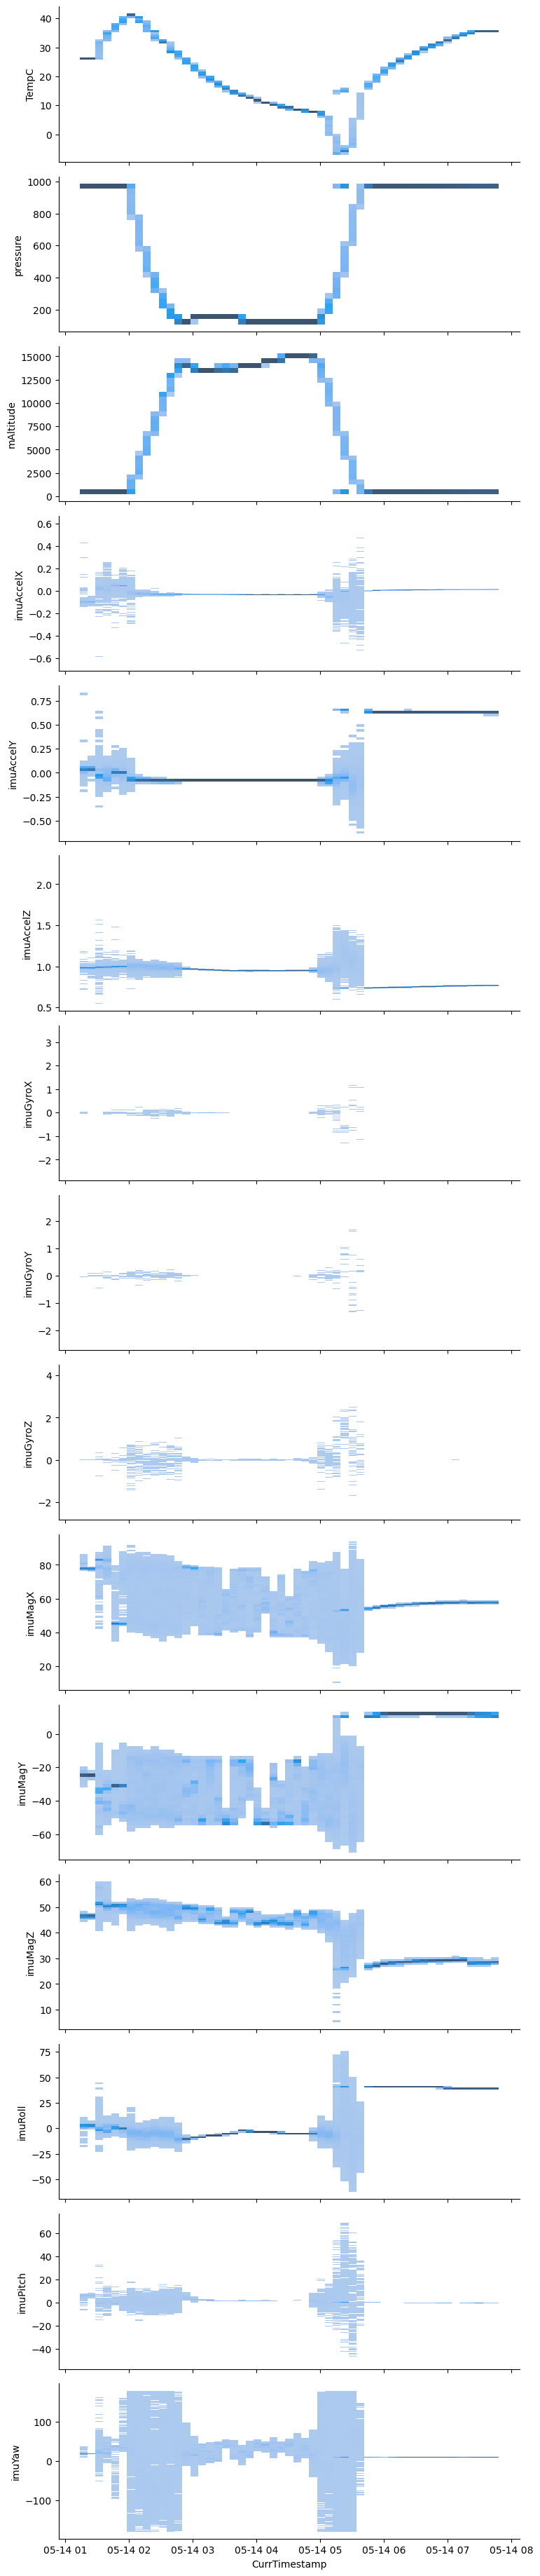

In [19]:
# View versus time
g = sns.PairGrid(imu_data, x_vars=['CurrTimestamp'], aspect=3)
g.map_offdiag(sns.histplot)

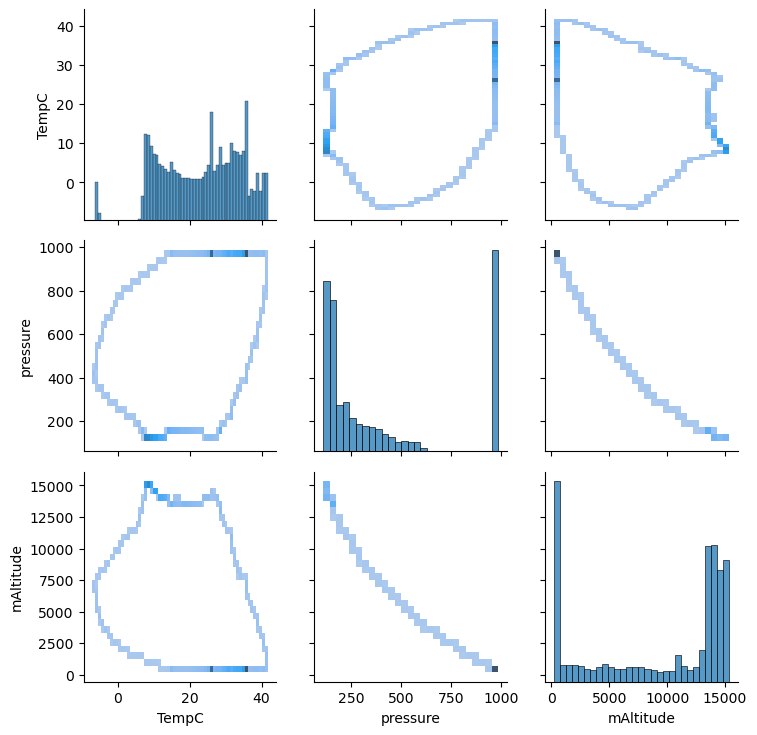

In [20]:
# Overview of altitude columns
g = sns.PairGrid(imu_data[ac_columns])
g.map_diag(sns.histplot)
g.map_offdiag(sns.histplot)

# Loop to set yscale of diagonal plots to log
for i, ax in enumerate(g.diag_axes):
    ax.set_yscale('log')

## Inspect a Random Image

In [21]:
fp = rng.choice(mm.flight.image_fps)

In [ ]:
img = mm.flight.get_rgb_img(fp)

AttributeError: 'Flight' object has no attribute 'flight'

In [ ]:
fp

In [ ]:
mm.data_viewer.plot_img(img)

In [ ]:
bins = np.arange(-0.5, mm.flight.max_val-0.5, 1)
plt_types = ['big_picture', 'zoomed', 'zoomed_upper']

# Look at brightness distribution
fig = plt.figure(figsize=(8*len(plt_types),6))

xlims = [ (bins[0], bins[-1]), (0, 50), (bins[-1]-100, bins[-1]) ]
ax_dict = fig.subplot_mosaic([plt_types,])

colors = ['red', 'green', 'blue']
for j, plt_type in enumerate(plt_types):
    
    ax = ax_dict[plt_types[j]]
    for i, color in enumerate(colors):
        
        arr = img[:,:,i] * mm.flight.max_val

        ax.hist(
            arr.flatten(),
            bins = bins,
            color = color,
            histtype = 'step',
        )
        ax.set_xlim(xlims[j])

    ax.set_yscale('log')
    
    ax.set_xlabel( 'Integer Value', )
    ax.set_ylabel( 'Frequency', )

## Inspect a Calibration Image

In [ ]:
image_dir = os.path.join( google_drive_dir, 'Shared drives/NITELite/Data & Analysis/Calibration Tests/3.19.22 Complete Calib Set/23085686_1sec_flatFrames' )

In [ ]:
glob.glob(os.path.join(image_dir, '*.raw'))